# **The code focuses on collecting articles from the German Wikipedia on a specific category (in this case, "Mathematics") using MediaWiki API**

In [1]:
# Import Necessary Libraries
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import numpy as np
from datasets import load_dataset

In [2]:
def get_articles_from_category(category, limit=10):
    S = requests.Session()
    URL = "https://de.wikipedia.org/w/api.php"
    
    # Parameters to get the list of pages in a category
    PARAMS = {
        "action": "query",
        "list": "categorymembers",
        "cmtitle": f"Category:{category}",
        "cmlimit": limit,
        "format": "json"
    }
    
    response = S.get(url=URL, params=PARAMS)
    data = response.json()
    pages = data['query']['categorymembers']
    
    articles = []
    
    for page in pages:
        pageid = page['pageid']
        title = page['title']
        
        # Parameters to get the content of each page
        PARAMS = {
            "action": "query",
            "pageids": pageid,
            "prop": "extracts",
            "explaintext": True,
            "format": "json"
        }
        
        response = S.get(url=URL, params=PARAMS)
        data = response.json()
        page_content = data['query']['pages'][str(pageid)]['extract']
        
        articles.append({'title': title, 'content': page_content})
        
    return articles

def download_articles(category, num_articles=100):
    articles = get_articles_from_category(category, num_articles)
    df = pd.DataFrame(articles)
    if not os.path.exists('data'):
        os.makedirs('data')
    df.to_csv('data/german_wikipedia_articles.csv', index=False)
    return df


In [3]:
category = 'mathematik'
df_articles = download_articles(category)

In [4]:
df_articles

,title,content
0,Mathematik,Die Mathematik (bundesdeutsches Hochdeutsch: [...
1,Portal:Mathematik,
2,Mathematics Genealogy Project,Das Mathematics Genealogy Project (deutsch mat...
3,Regius Professor of Mathematics (Oxford),Der Regius Professor of Mathematics ist eine 2...
4,1 + 1 = 2,"1 + 1 = 2 ist eine mathematische Gleichung, di..."
...,...,...
78,Kategorie:Ungleichung,Die Kategorie Ungleichungen enthält Artikel zu...
79,Kategorie:Veranstaltung (Mathematik),
80,Kategorie:Vermutung (Mathematik),In diese Kategorie gehören mathematische Vermu...
81,Kategorie:Zahl,Diese Kategorie enthält Artikel die sich mit d...


In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('german'))

df = pd.read_csv('data/german_wikipedia_articles.csv')

# Display basic information about the dataset
print(f'Number of articles: {df.shape[0]}')
print(df.describe())

df.replace([np.inf, -np.inf], np.nan,inplace=True)
df.dropna(inplace=True)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Number of articles: 83
             title                                            content
count           83                                                 65
unique          83                                                 65
top     Mathematik  Die Mathematik (bundesdeutsches Hochdeutsch: [...
freq             1                                                  1


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


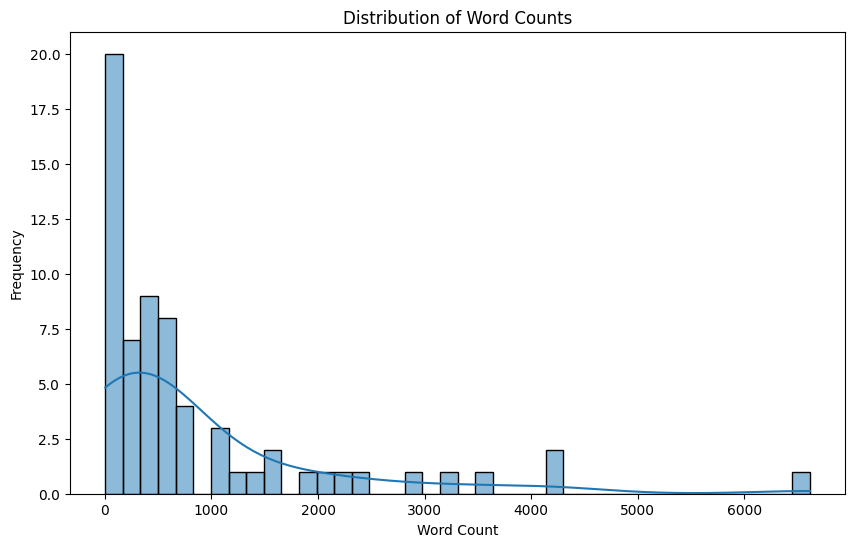

In [6]:
# Word count analysis
df['word_count'] = df['content'].apply(lambda x: len(x.split()))

# Plot the distribution of word counts
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=40, kde=True)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

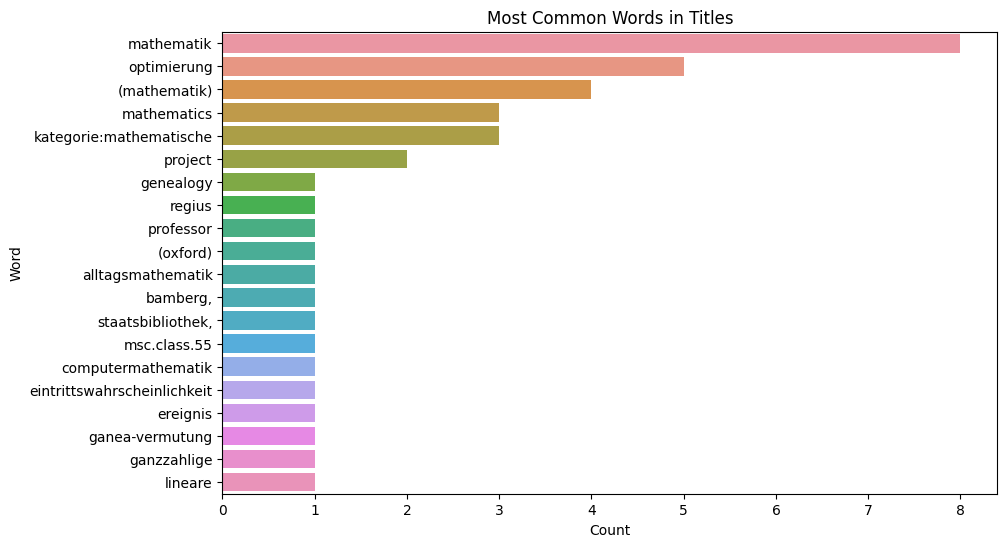

In [7]:
# Most common words in titles
title_words = ' '.join(df['title']).lower().split()
title_words = [word for word in title_words if word not in stop_words and len(word) > 2]
title_word_counts = Counter(title_words)

# Plot the most common words in titles
title_common_words = title_word_counts.most_common(20)
title_common_words_df = pd.DataFrame(title_common_words, columns=['word', 'count'])

plt.figure(figsize=(10, 6))
sns.barplot(data=title_common_words_df, x='count', y='word')
plt.title('Most Common Words in Titles')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

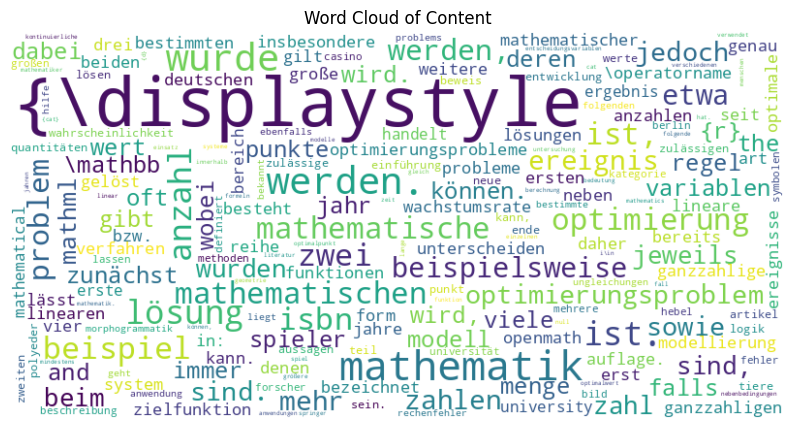

In [8]:
# Most common words in content
content_words = ' '.join(df['content']).lower().split()
content_words = [word for word in content_words if word not in stop_words and len(word) > 2]
content_word_counts = Counter(content_words)

# Generate word cloud for content
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(content_word_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Content')
plt.show()


# **There is an existing dataset on Hugging Face called "legacy-datasets/wikipedia" which contains preprocessed Wikipedia articles. The subset for German articles dated March 1, 2022 (20220301.de), contains content of the articles and metadata related to each article**

In [9]:
dataset = load_dataset('legacy-datasets/wikipedia', '20220301.de')
df = pd.DataFrame(dataset['train'])

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for legacy-datasets/wikipedia contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/legacy-datasets/wikipedia
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/2665357 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665357 entries, 0 to 2665356
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      object
 1   url     object
 2   title   object
 3   text    object
dtypes: object(4)
memory usage: 81.3+ MB


In [11]:
df.head()

,id,url,title,text
0,1,https://de.wikipedia.org/wiki/Alan%20Smithee,Alan Smithee,Alan Smithee steht als Pseudonym für einen fik...
1,3,https://de.wikipedia.org/wiki/Actinium,Actinium,Actinium ist ein radioaktives chemisches Eleme...
2,5,https://de.wikipedia.org/wiki/Ang%20Lee,Ang Lee,"Ang Lee (; * 23. Oktober 1954 in Chaozhou, Lan..."
3,7,https://de.wikipedia.org/wiki/Anschluss%20%28L...,Anschluss (Luhmann),Anschluss ist in der Soziologie ein Fachbegrif...
4,10,https://de.wikipedia.org/wiki/Aussagenlogik,Aussagenlogik,Die Aussagenlogik ist ein Teilgebiet der Logik...
